In [310]:
import numpy as np
import os
import do_mpc
import casadi
import matplotlib.pyplot as plt
import matplotlib as mpl

from carenv import CarEnv

# Customizing Matplotlib:
mpl.rcParams['axes.grid'] = True


In [311]:
T_STEP = 0.1
SETPOINT = np.array([50, 100, np.pi/4, 0])
ENV_SIZE = (1200, 1000)


## Configure the model

In [312]:
model = do_mpc.model.Model("continuous")

In [313]:
'''
states _x

x_pos
y_pos
theta - heading angle
delta - steering angle
'''
x_pos = model.set_variable(var_type="_x", var_name="x_pos", shape=(1, 1))
y_pos = model.set_variable(var_type="_x", var_name="y_pos", shape=(1, 1))
theta = model.set_variable(var_type="_x", var_name="theta", shape=(1, 1))
delta = model.set_variable(var_type="_x", var_name="delta", shape=(1, 1))

In [314]:
'''
inputs _u

v - velocity
phi - steering rate
'''
v = model.set_variable(var_type="_u", var_name="v")
phi = model.set_variable(var_type="_u", var_name="phi")

In [315]:
'''
parameters _p

L - vehicle length
'''
L = 30

In [316]:
'''
rhs (first order differential equasions of _x)
'''
d_x_pos = v * np.cos(theta)
d_y_pos = v * np.sin(theta)
d_theta = v * np.tan(delta) / L
d_delta = phi

model.set_rhs("x_pos", d_x_pos)
model.set_rhs("y_pos", d_y_pos)
model.set_rhs("theta", d_theta)
model.set_rhs("delta", d_delta)

In [317]:
model.setup()

## MPC setup

In [318]:
mpc = do_mpc.controller.MPC(model)

mpc.set_param(
    n_horizon = 20,
    t_step = T_STEP,
    n_robust = 1,
    store_full_solution = True,
)

In [319]:
mterm = (x_pos-SETPOINT[0])**2 + (y_pos-SETPOINT[1])**2 + (theta-SETPOINT[2])**2 + (delta-SETPOINT[3])**2
lterm = mterm

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(
    v=1e-2,
    phi=1e-2
)

In [320]:
mpc.bounds['lower', '_x', 'x_pos'] = 0
mpc.bounds['upper', '_x', 'y_pos'] = ENV_SIZE[0]

mpc.bounds['lower', '_x', 'y_pos'] = 0
mpc.bounds['upper', '_x', 'y_pos'] = ENV_SIZE[1]

mpc.bounds['lower', '_x', 'delta'] = -np.pi/4
mpc.bounds['upper', '_x', 'delta'] = np.pi/4

In [321]:
mpc.bounds['lower', '_u', 'v'] = -80
mpc.bounds['upper', '_u', 'v'] = 80

# TODO: RANDOM VALUES FOR NOW
mpc.bounds['lower', '_u', 'phi'] = -np.pi/4
mpc.bounds['upper', '_u', 'phi'] = np.pi/4

In [322]:
mpc.setup()

## Simulator

In [323]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=T_STEP)
simulator.setup()

In [324]:
%%capture

sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name="x_pos", axis=ax[0])
    g.add_line(var_type='_x', var_name="y_pos", axis=ax[0])
    g.add_line(var_type='_x', var_name="theta", axis=ax[0])
    g.add_line(var_type='_x', var_name="delta", axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name="v", axis=ax[1])
    g.add_line(var_type='_u', var_name="phi", axis=ax[1])


ax[0].set_ylabel('states')
ax[1].set_ylabel('steering')
ax[1].set_xlabel('time [s]')

In [325]:
x0 = np.array([900, 900, np.pi/2, np.pi/6]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0

mpc.set_initial_guess()

In [326]:
%%capture

sim_time = 20

try:
    with CarEnv(L=L, setpoint=SETPOINT, env_size=ENV_SIZE, t_step=T_STEP) as env:
        for i in range(int(sim_time * 1/T_STEP)):
            u0 = mpc.make_step(x0)
            x0 = simulator.make_step(u0)
            env.make_step(x0)

except SystemExit:
    pass

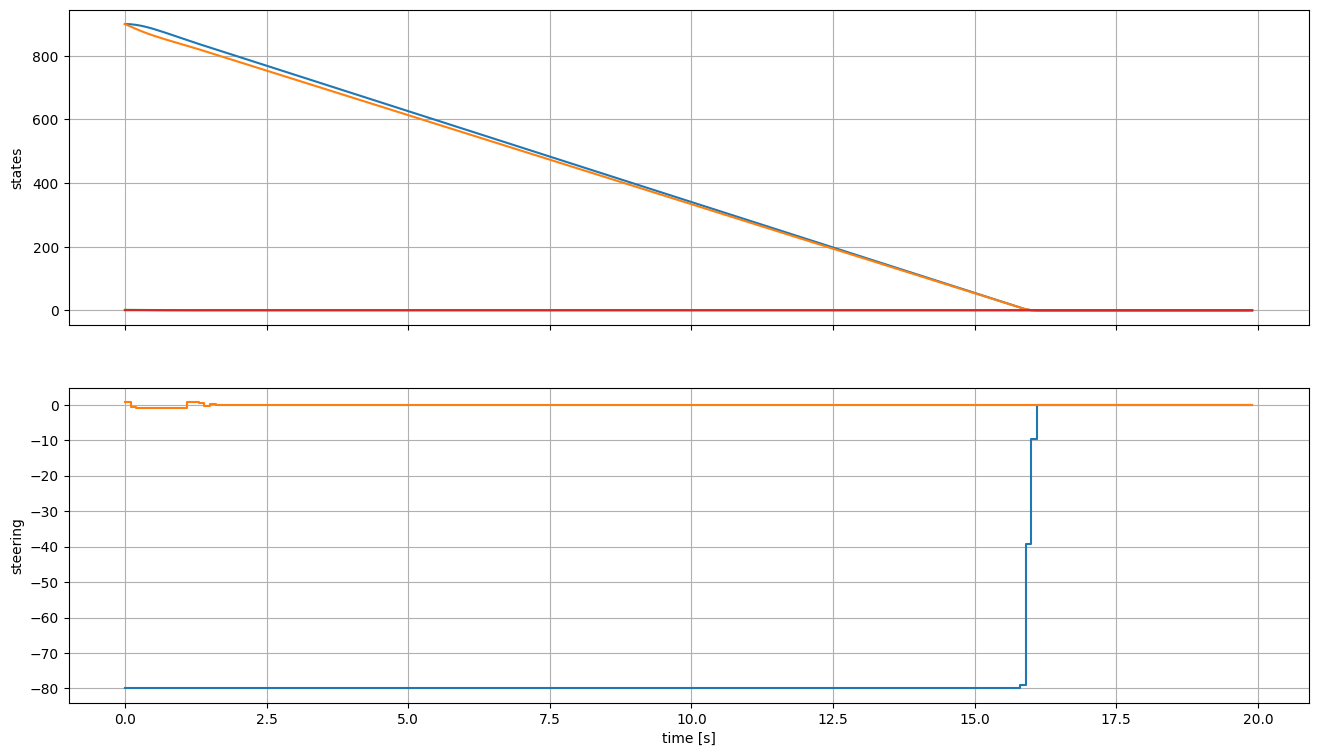

In [275]:
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig